# Simulate random variable following an exponential distribution

### Metod 1 (optimal): apply quantile to uniform pseudo-random values 

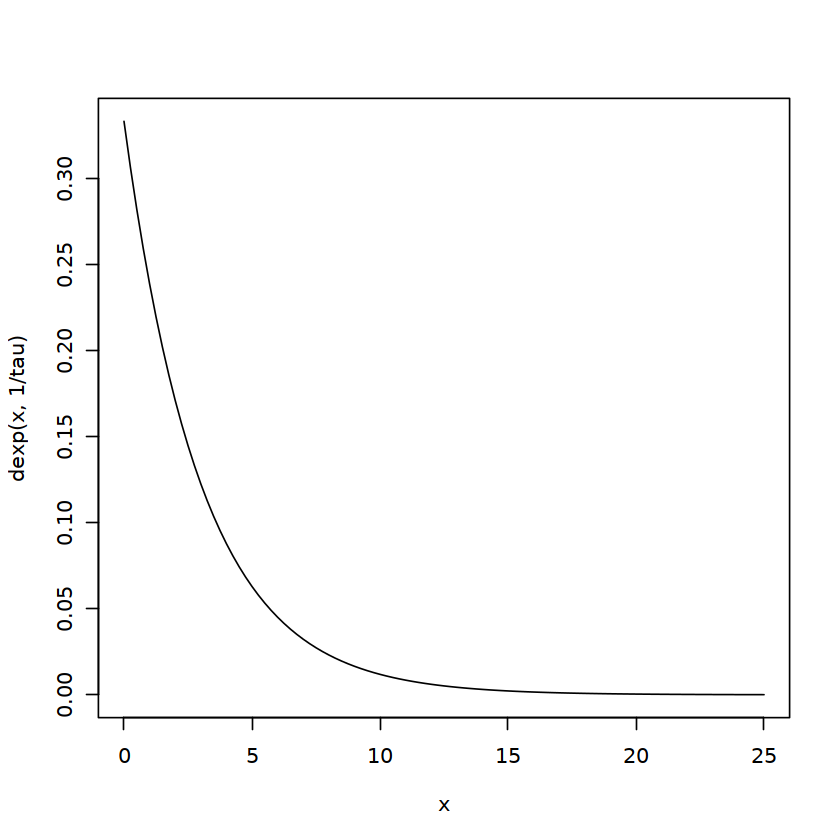

In [1]:
N=10000
tau=3

curve(dexp(x,1/tau),0,25)

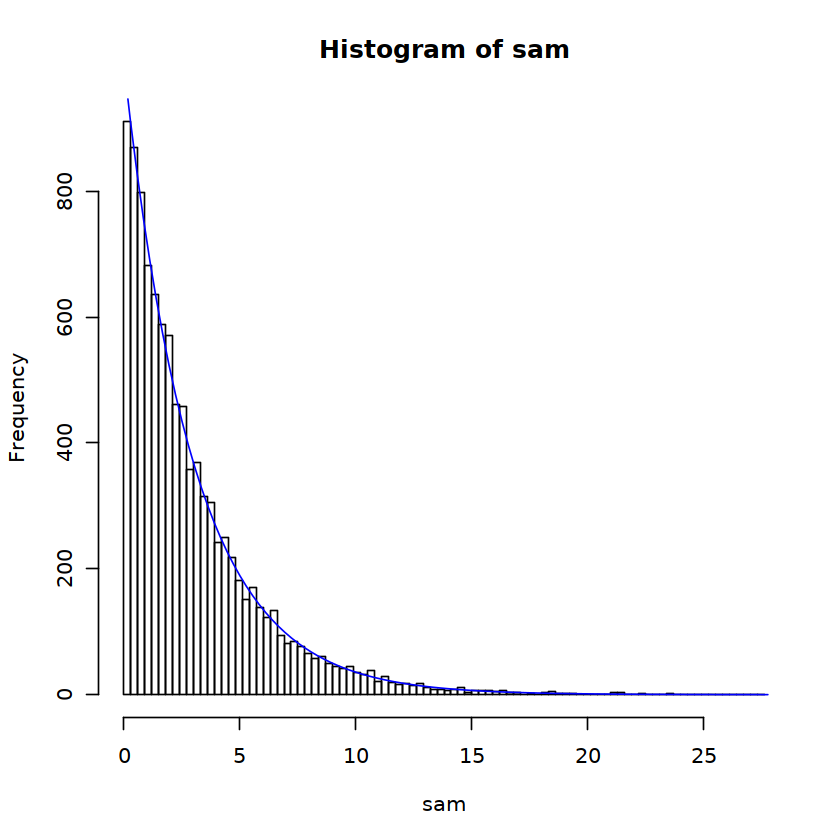

In [2]:
sample0= rexp(N, 1/tau)

checkExpSample = function(sam,tau) {
 delta=tau/10
 hist(sam,breaks=seq(0,max(sam)*1.05,delta))
 curve(dexp(x,1/tau)*length(sam)*delta, 0, max(sam)*1.05, add=T, col="blue" )
}

checkExpSample(sample0,tau)

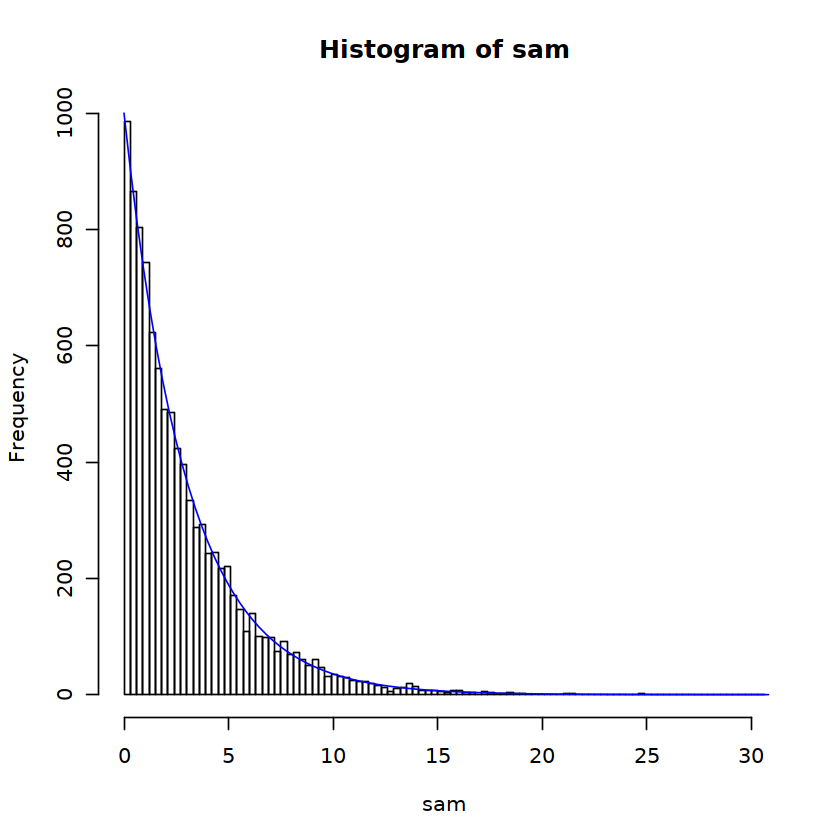

In [3]:
# equivalent to:
unifsample=runif(N)
sample=-tau*log(1-unifsample)

checkExpSample(sample,tau)

### Method 2: use the Metropolis algorithm

In [4]:
ExpMetropolis = function(N,tau) {
 out=c()
 x=tau # start from the expected value
 
 while (length(out)<N) {
   accept=FALSE
   step=rnorm(1,sd=tau/2.) # we use normal as proposal function for  (must be symmetric) 
   xp=x+step
   if(step<0 && xp>0) {
     accept=TRUE # function is larger in xp
   }
   else {        
       accept = (runif(1) < dexp(xp,1/tau)/dexp(x,1/tau))
   }
   # cat ("accept is ",accept," N=",length(out),"x, xp=",x,"  ",xp,"\n")
   if (accept==TRUE) {x=xp}
   out = c(out, x)   
 }
 out
}

In [5]:
N=50000
myMCMC=ExpMetropolis(N,tau)

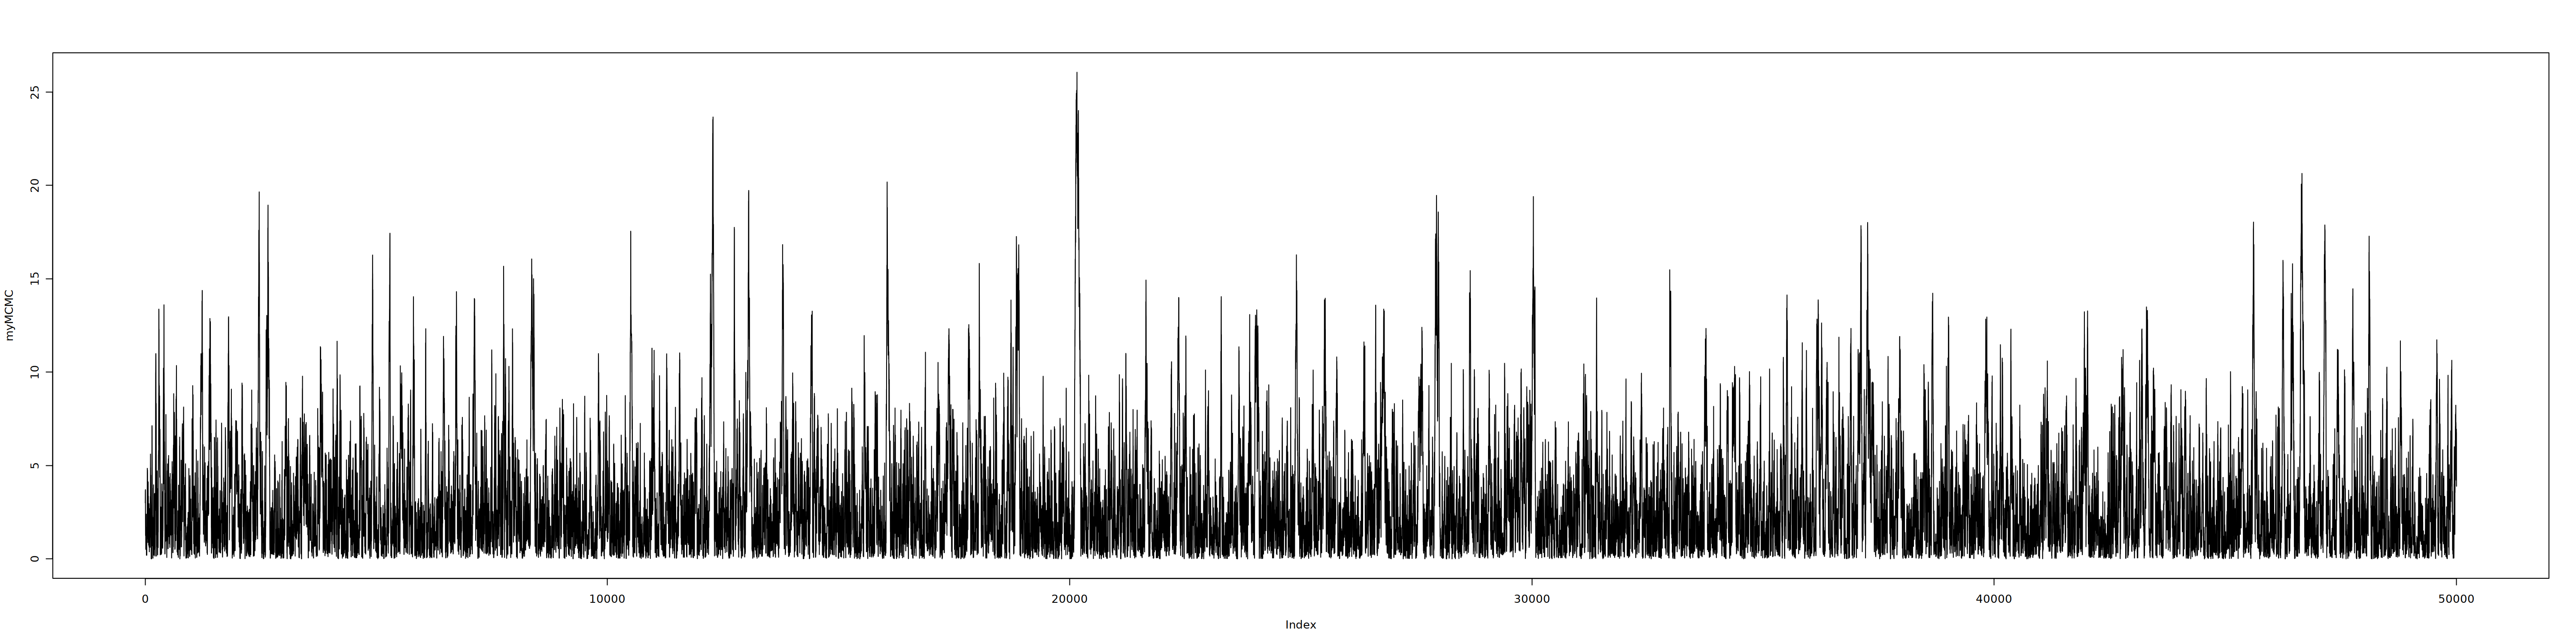

In [6]:
options(repr.plot.width = 40, repr.plot.height = 10, repr.plot.res = 150)
plot(myMCMC,type="l")

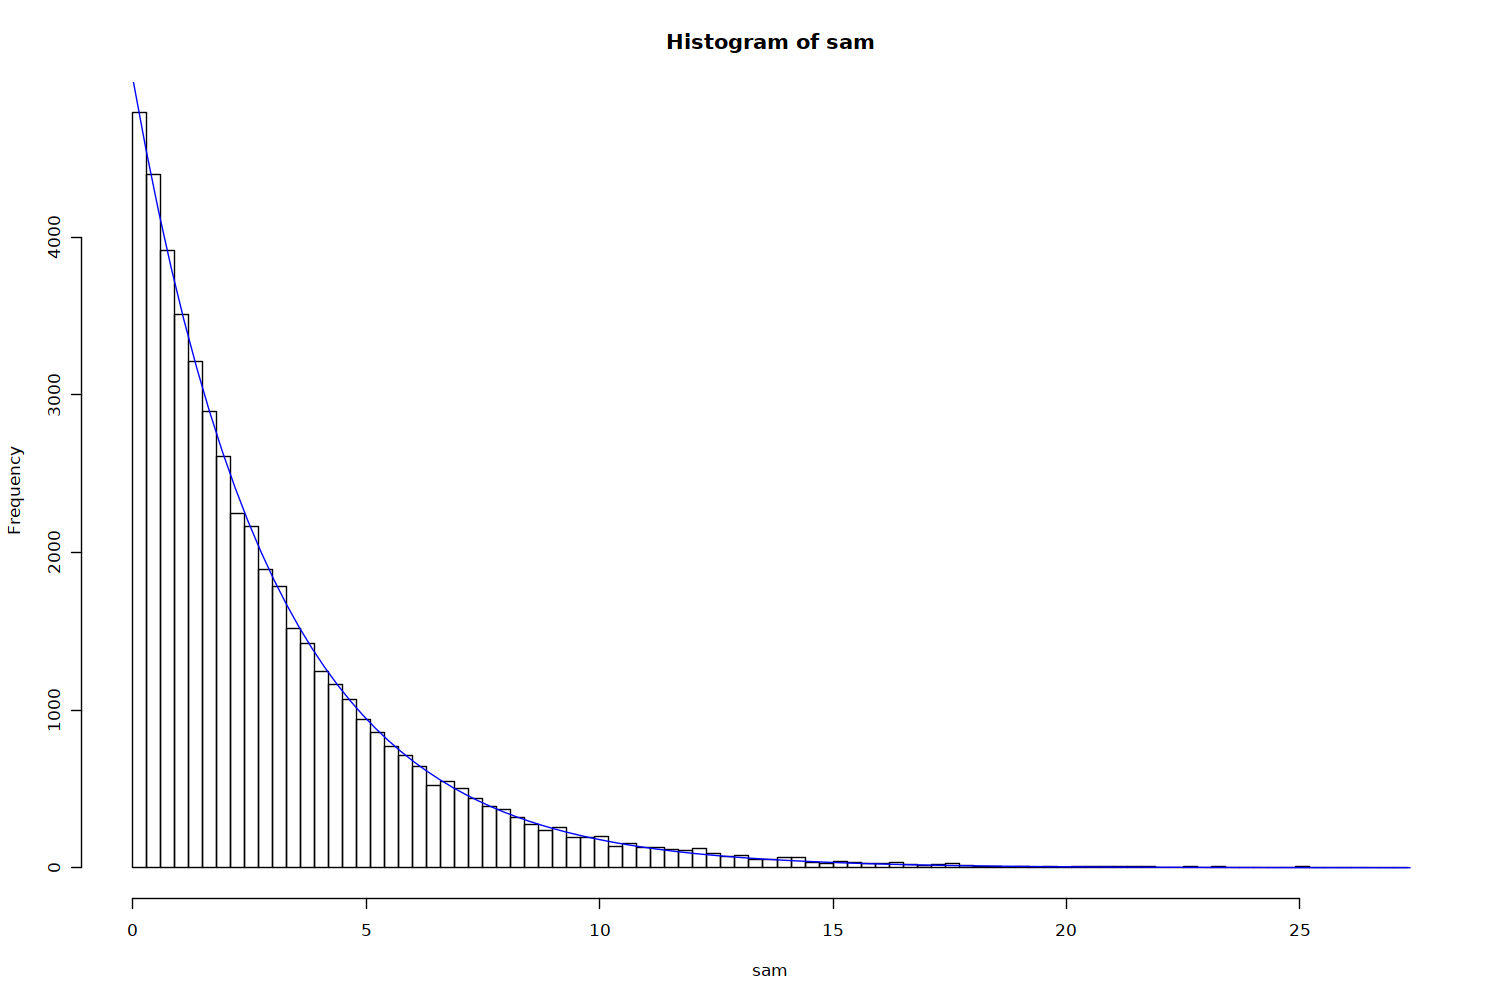

In [7]:
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 100)
checkExpSample(myMCMC,tau)

# Now use MCMC to estimate Rt from first data in Tuscany

In [8]:
# first incidence data in Tuscany
Idata= c(
     0,     2,     0,     0,     6,     3,     2,     0,     6,    19,    23,    18,
    34,    53,    42,    56,    56,    44,   106,   160,   151,    85,   187,   277)

## --------- parameters ------------
# the day for which we want the estimate
EstimateDay=length(Idata)
# windows in days for Rt estimation
Delta=7
# best value and error for k and r (infectivity function parameters)
kbest=1.87
sigmak=0.26
rbest=0.28
sigmar=0.04
# prior for Rt
a=1
b=1./5

best estimate for Rt: 2.705253   90% CL interval is  2.566845  ->  2.846704 


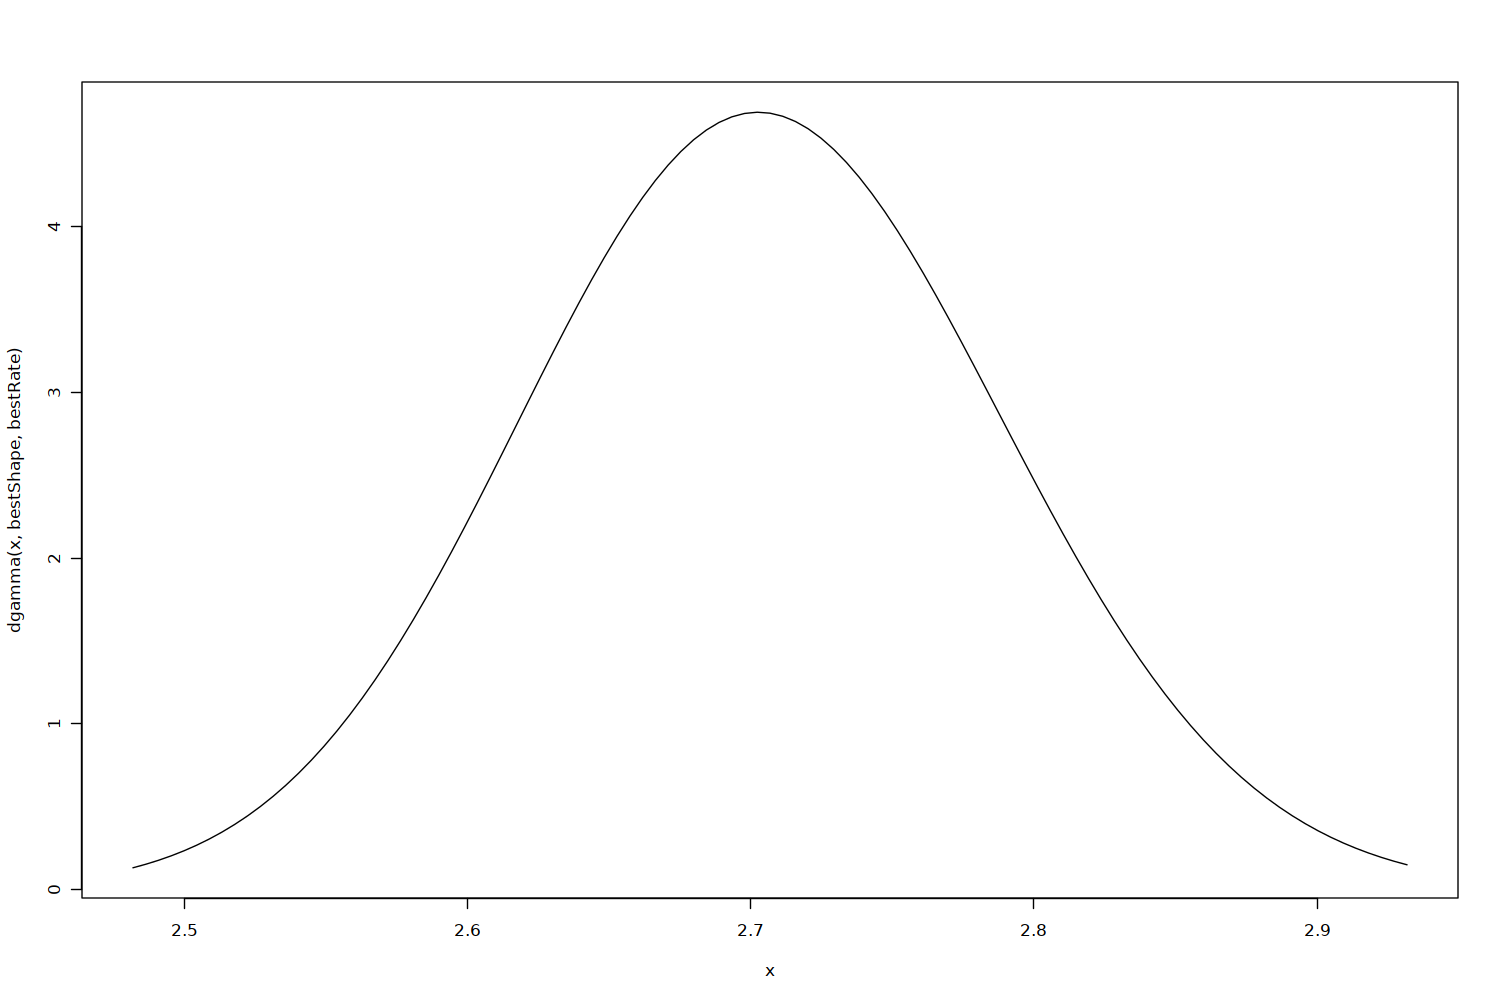

In [9]:
# sum of I over time window
sumIt= sum( Idata[(EstimateDay-Delta+1):EstimateDay] )

#sum of lambdas over time window
mysumLambda = function(k,r) {
 sumLambda=0
 for ( i in (EstimateDay-Delta+1):EstimateDay ) {
  for (s in 1:(i-1)) {
   sumLambda = sumLambda+Idata[i-s]*dgamma(s,k,r)
  } 
 }
 sumLambda
}

# Rt estimate with no systematics on infectivity function
bestShape=1+sumIt
bestRate=1+mysumLambda(kbest,rbest)
bestRt = bestShape/bestRate
minRt=qgamma(0.05,bestShape,bestRate)
maxRt=qgamma(0.95,bestShape,bestRate)
cat ("best estimate for Rt:",bestRt, "  90% CL interval is ",
  minRt, " -> ", maxRt,"\n")
curve (dgamma(x,bestShape,bestRate),minRt-sqrt(bestShape)/bestRate,maxRt+sqrt(bestShape)/bestRate)

### Metropolis-Hastings algorithm to compute posterior for Rt including uncertainties on r and k

In [10]:
#target distribution is the posterior function we want to simulate
target = function (Rt, k, r) {
dgamma(Rt, a+sumIt, b+mysumLambda(k,r) ) * dnorm (k, kbest, sigmak) * dnorm(r, rbest, sigmar)
} 

# proposal (transition) distribution for random walk:
#  same shape as target, with previous step as average values
proposal = function (Rt, k, r, Rtp, kp, rp) {
 dgamma(Rtp, bestShape, bestShape/Rt ) * dnorm (kp, k, sigmak) * dnorm(rp, r, sigmar)
}


# Metropolis-Hastings algorithm to simulate the Rt posterior
RtMH = function(N=10000) {
 out=c()
 Rt=bestRt
 k=kbest
 r=rbest

 while (length(out)<N) {
   accept=FALSE
   # draw from  proposal distribution 
   Rtp= rgamma(1, bestShape, bestShape/Rt)
   kp= rnorm(1, k,  sigmak)
   rp= rnorm(1, r,  sigmar)
  
   # as the proposal distribution is not symmetric, we use the Metropolis-Hastings version
   Ratio = 0
   tgt=target(Rt, k, r)
   prop=proposal (Rt, k, r, Rtp, kp, rp)
   if (tgt>0 && prop>0) {
    Ratio= target(Rtp, kp, rp) / prop *
           proposal (Rtp, kp, rp, Rt, k, r) / tgt
   }   

   if(Ratio>1) {
     accept=TRUE
   }
   else {        
       accept = (runif(1) < Ratio)
   }
   # cat ("accept is ",accept," N=",length(out),"Rt, Rtp=",Rt,"  ",Rtp,"\n")
   if (accept==TRUE) {
    Rt=Rtp
    k=kp
    r=rp
   }
   out = c(out, Rt)   
 }
 out

}

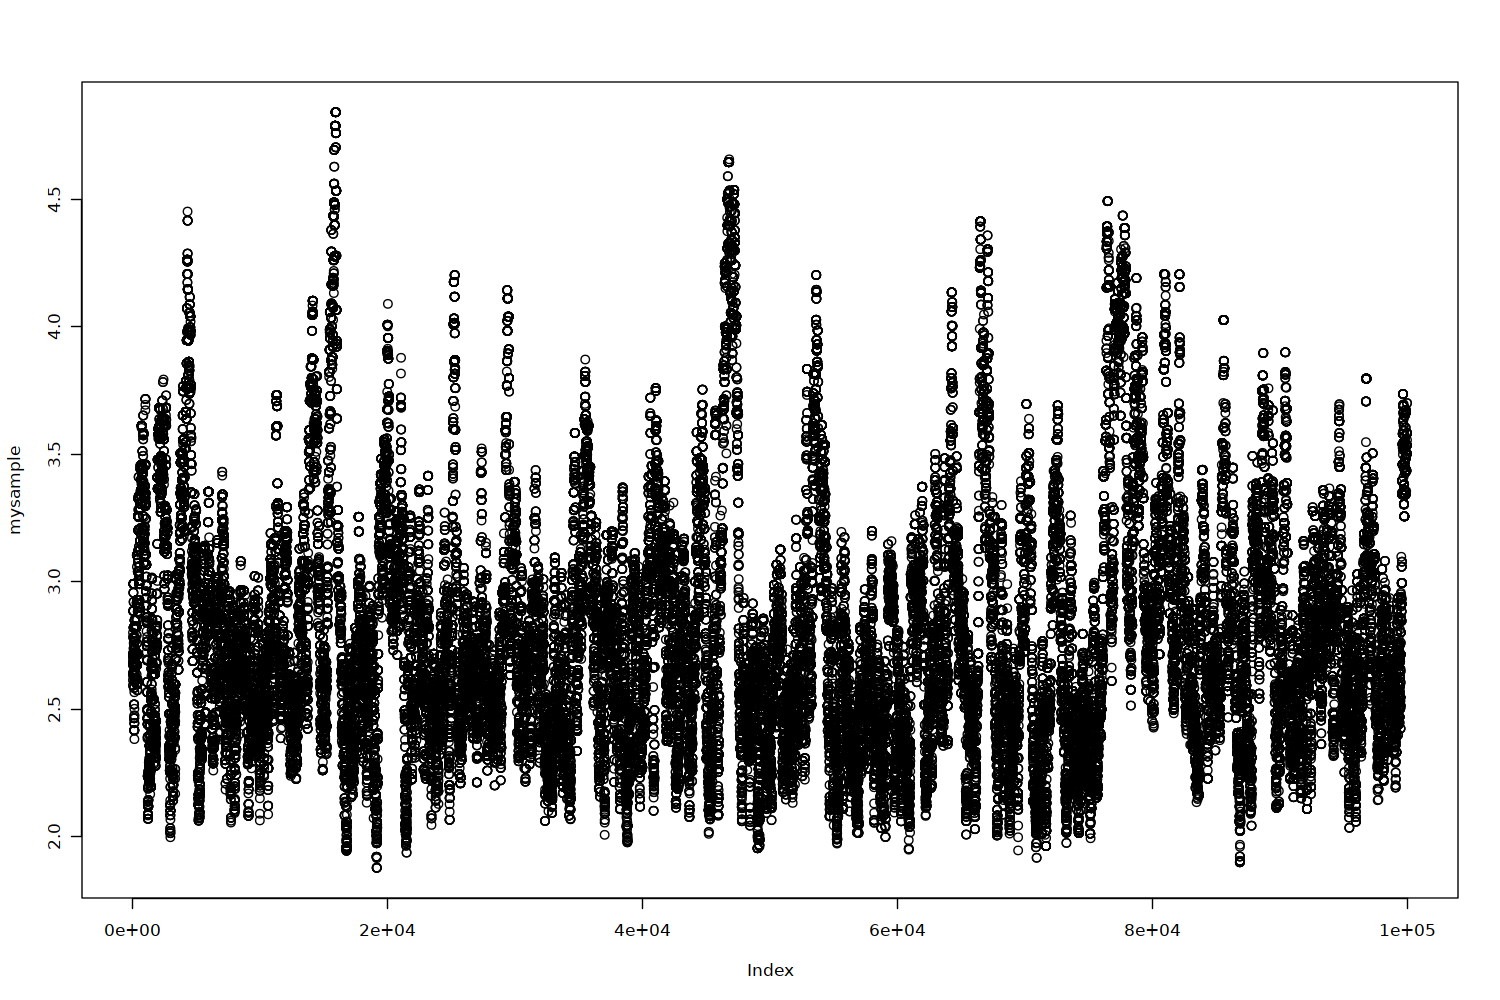

In [11]:
N=100000
mysample=RtMH(N)
plot(mysample)

best estimate for Rt from MCMC-MH: 2.814946   90% CL interval is 


5%      95% 
2.208189 3.758376

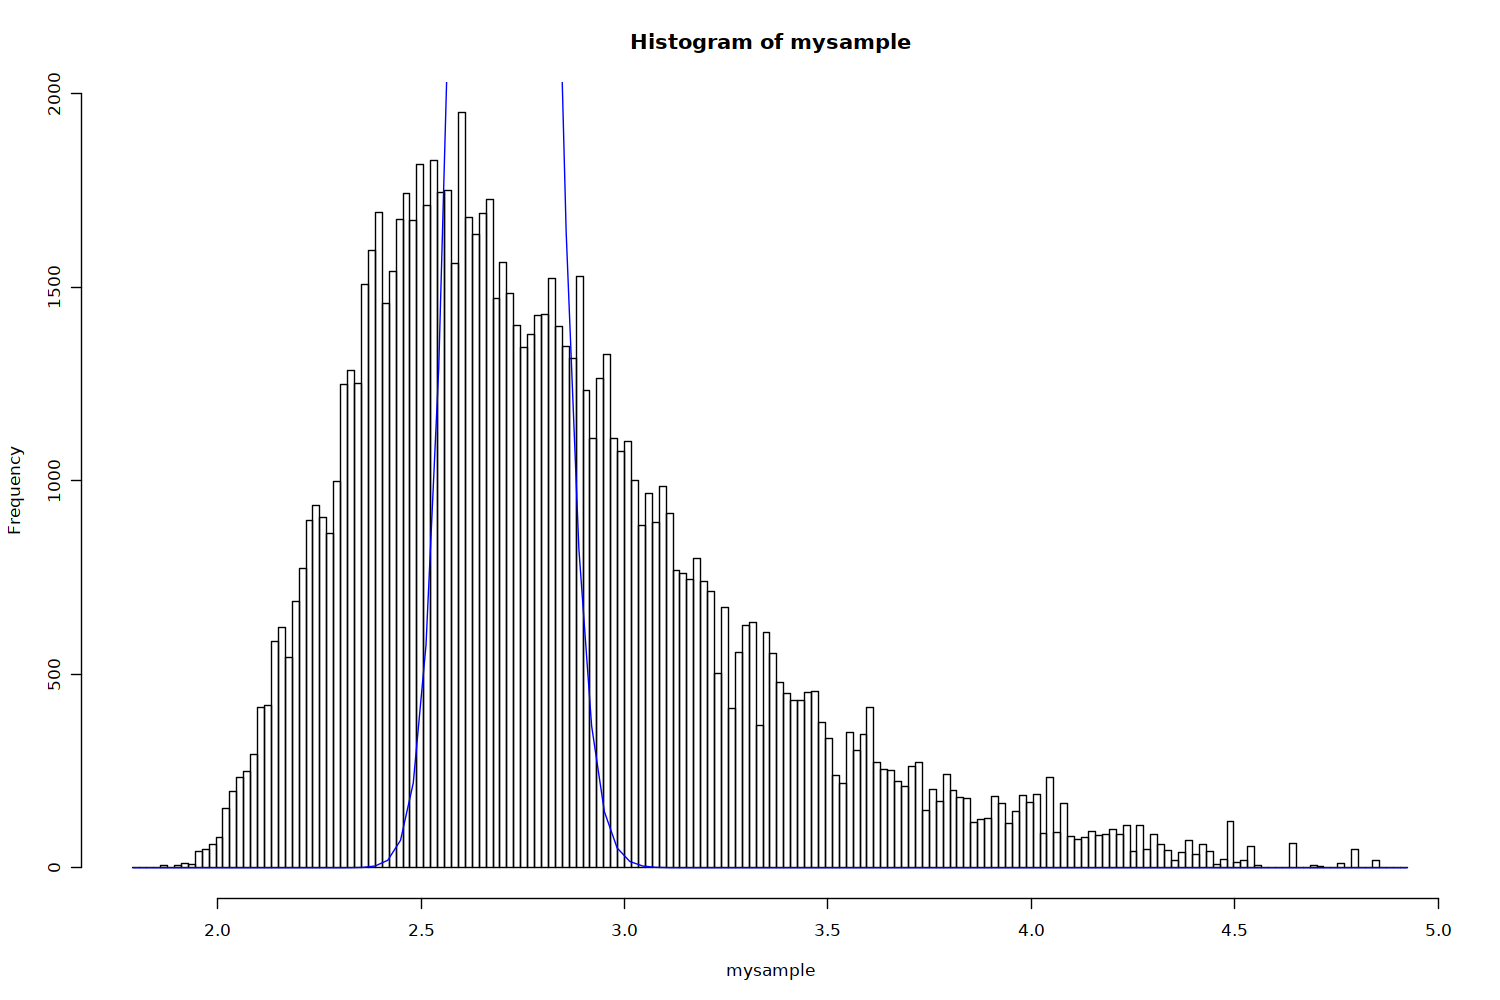

In [12]:
delta=sqrt(bestShape)/bestRate/5
hist(mysample,breaks=seq(min(mysample)-5*delta,max(mysample)+5*delta,delta) )
curve (dgamma(x,bestShape,bestRate) *length(mysample)*delta, add=T,col="blue")
cat ("best estimate for Rt from MCMC-MH:", mean(mysample), "  90% CL interval is \n")
quantile(mysample, c(0.05,0.95))

### As the distribution is the product of conditional probabilities, we can use a Gibbs samper (more efficient) 

In [13]:
RtGS = function(N=10000) {
 out=c()
 while (length(out)<N) {
   # draw according to conditional probabilties
   k= rnorm(1, kbest,  sigmak) # this is independent from other variables
   r= rnorm(1, rbest,  sigmar) # this is independent from other variables
   if (k >0 && r>0) {
    thisRate=1+mysumLambda(k,r)
    Rt= rgamma(1, bestShape, thisRate)
    out = c(out, Rt)   
   }
 }
 out
}


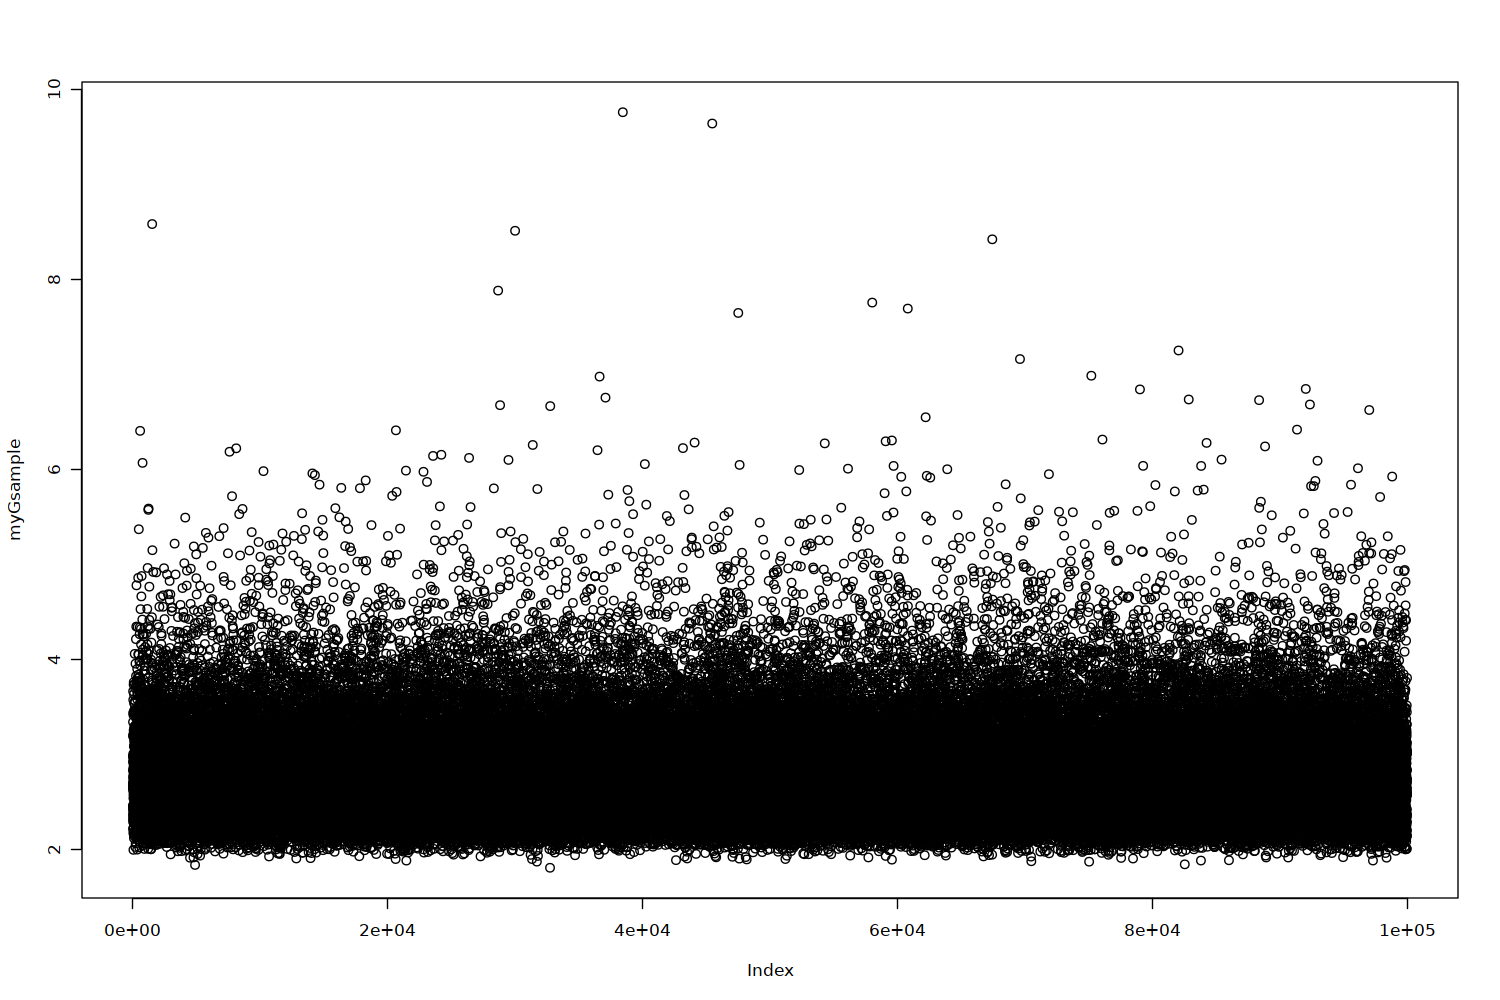

In [14]:
myGsample=RtGS(N)
plot(myGsample)

best estimate for Rt from MCMC-GS: 2.80224   90% CL interval is 


5%      95% 
2.199400 3.716536

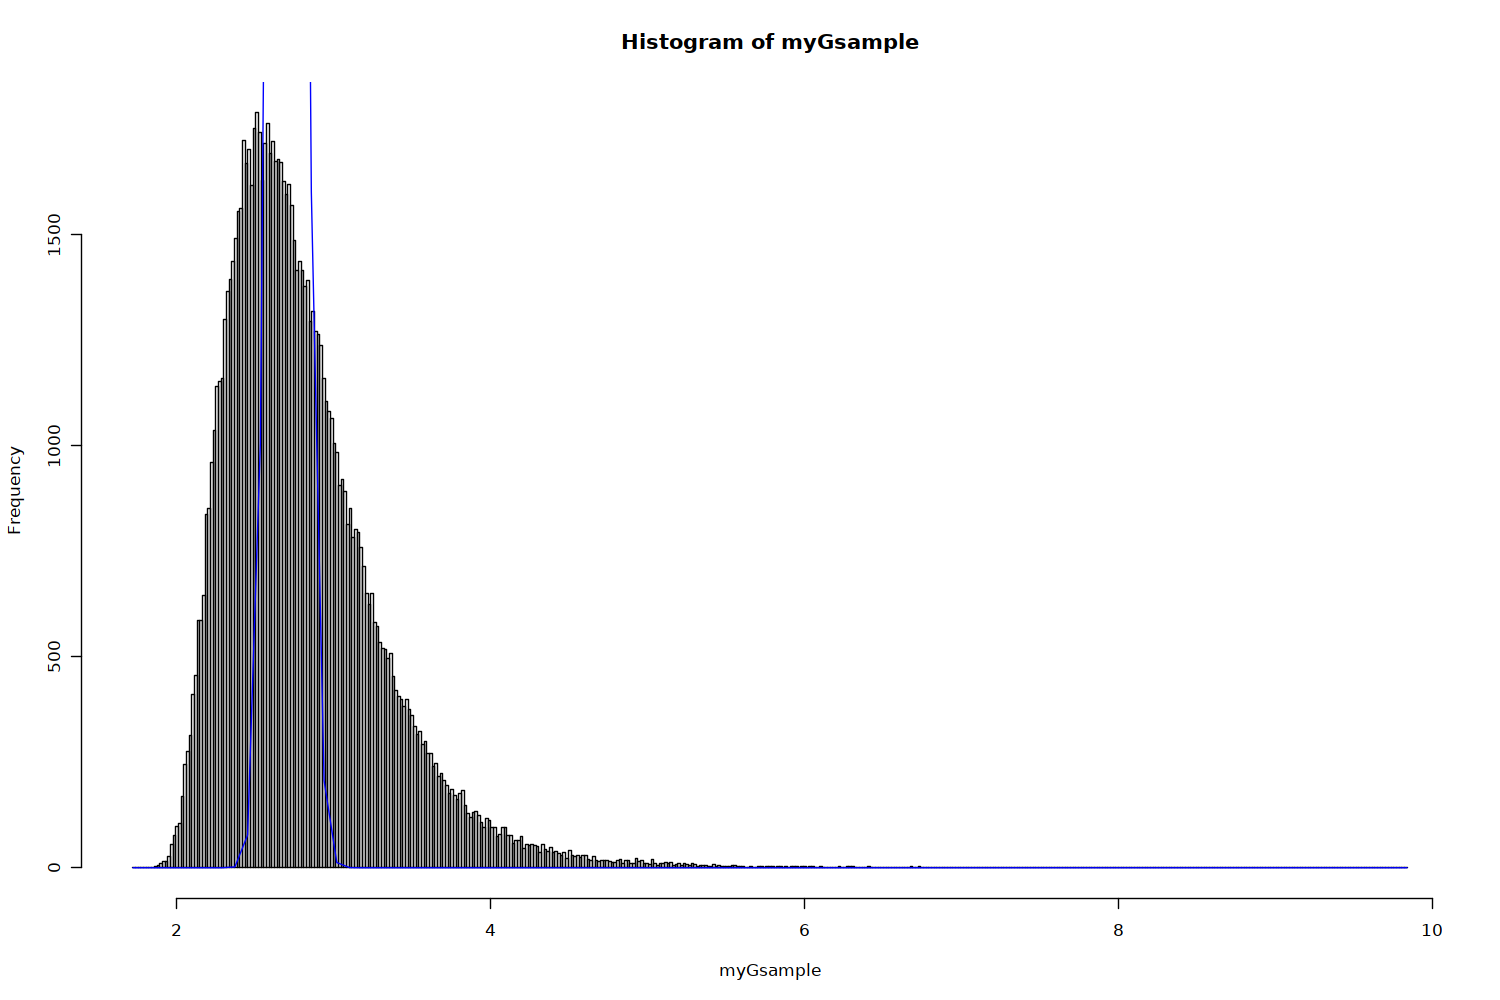

In [15]:
hist(myGsample,breaks=seq(min(myGsample)-5*delta,max(myGsample)+5*delta,delta) )
curve (dgamma(x,bestShape,bestRate) *length(mysample)*delta, add=T,col="blue")
cat ("best estimate for Rt from MCMC-GS:", mean(myGsample), "  90% CL interval is \n")
quantile(myGsample, c(0.05,0.95))